In [1]:
import glob
import numpy as np
import matplotlib.image as mpimg
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

imgpoints = []
objpoints = []

images = glob.glob('camera_cal/calibration*.jpg')

objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

#Finding chessboard corners and storing them in imagepoints and objpoints for all calibration images.

for fname in images:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray,(9,6), None)
    if ret:
        imgpoints.append(corners)
        objpoints.append(objp)

In [26]:
#Calculating camera calibration matrix distortion matrix
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [28]:
#function to unbdistort image by using camera clibration matrix and distortion matrix
def undistort_image(img, dist, mtx):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst


In [4]:
#functiuon which applies luminance thresholding and returns binary image
def luminance_thres(img, thresh):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    val = hls[:,:,1]
    binary = np.zeros_like(val)
    binary[(val>thresh[0]) & (val<=thresh[1])] = 1
    return binary

#functiuon which applies saturation thresholding and returns binary image
def saturation_thres(img, thresh):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    val = hls[:,:,2]
    binary = np.zeros_like(val)
    binary[(val>thresh[0]) & (val<=thresh[1])] = 1
    return binary

#functiuon which sobel direction luminance thresholding and returns binary image
def abs_sobel_dir(img, thresh, sobel_kernel):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    val = np.arctan2(abs_sobely, abs_sobelx)
    binary = np.zeros_like(gray)
    binary[(val>thresh[0]) & (val<=thresh[1])] = 1
    return binary

#functiuon which applies sobel x thresholding and returns binary image
def abs_sobel_x(img, thresh, sobel_kernel):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobelx)
    val = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary = np.zeros_like(gray)
    binary[(val>thresh[0]) & (val<=thresh[1])] = 1
    return binary

#functiuon to get region of interest
def region_of_interest(img, vertices):
    mask = np.zeros_like(img)   
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

#functiuon which combines all thresholding and region mask technique to calculate final thresholded image
def thresholding(undistorted):
    ysize = img.shape[0]
    xsize = img.shape[1]

    leftBottom = [round(0.1*xsize),ysize]
    leftTop = [round(0.437*xsize),round(0.61*ysize)]
    rightTop = [round(0.564*xsize),round(0.61*ysize)]
    rightBottom = [round(0.94*xsize),ysize]
    saturation_threshold = saturation_thres(undistorted, (80, 255))
    luminance_threshold = luminance_thres(undistorted, (100, 255))
    sobel_x = abs_sobel_x(undistorted, (30, 100),3)
    sobel_dir = abs_sobel_dir(undistorted, (0.7, 1.3),3)

    roi_satu = region_of_interest(saturation_threshold, [np.array([leftBottom,leftTop,rightTop,rightBottom], dtype=np.int32)])
    roi_luminance = region_of_interest(luminance_threshold, [np.array([leftBottom,leftTop,rightTop,rightBottom], dtype=np.int32)])
    roi_sobeld = region_of_interest(sobel_dir, [np.array([leftBottom,leftTop,rightTop,rightBottom], dtype=np.int32)])
    roi_sobelx = region_of_interest(sobel_x, [np.array([leftBottom,leftTop,rightTop,rightBottom], dtype=np.int32)])

    binary = np.zeros_like(roi_satu)
    binary[((roi_satu==1) & (roi_luminance==1))|((roi_sobeld==1) & (roi_sobelx==1))] = 1
    return binary

#functiuon to calculate radious of curvature
def radious_of_curvature(fitx, length):
    ploty = np.linspace(0, length-1, length )
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(ploty*ym_per_pix, fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    y_eval = np.max(ploty)
    return ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])

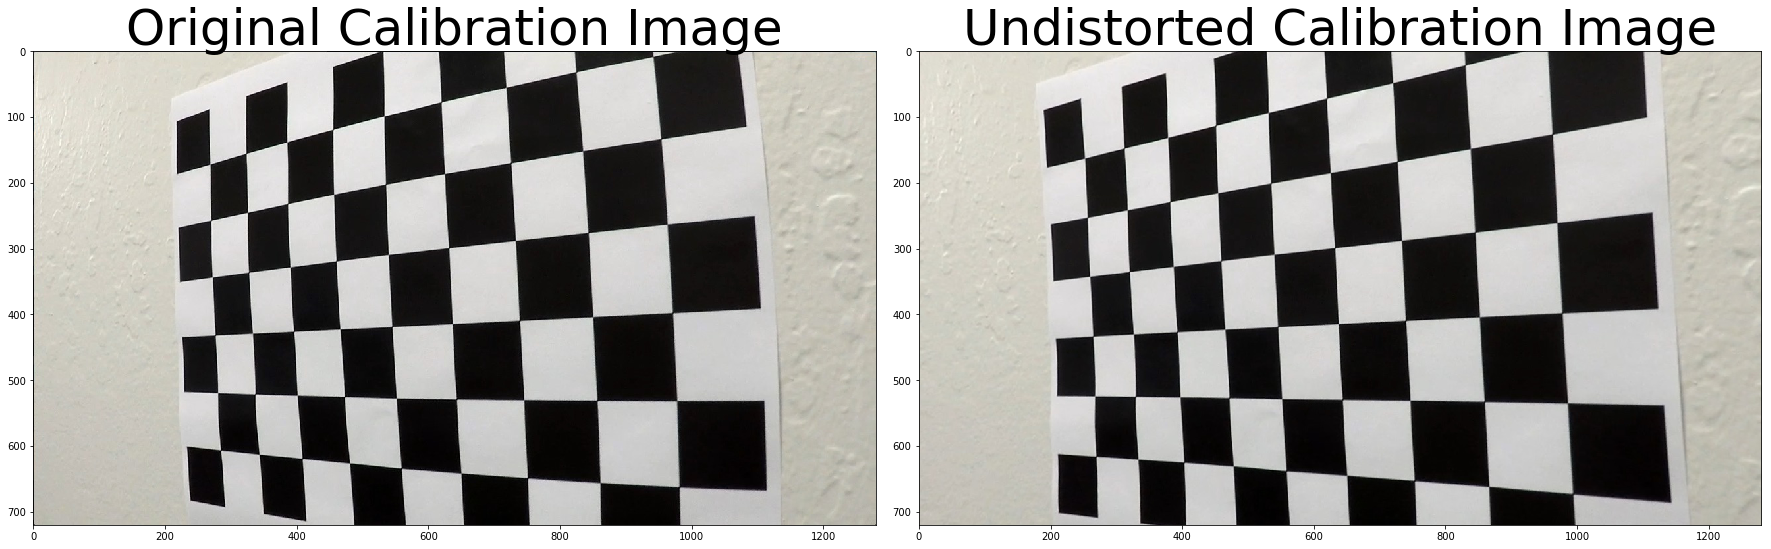

In [22]:
chess_img = mpimg.imread('camera_cal\\calibration4.jpg')



chess_undistorted = undistort_image(img, dist, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Calibration Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Calibration Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

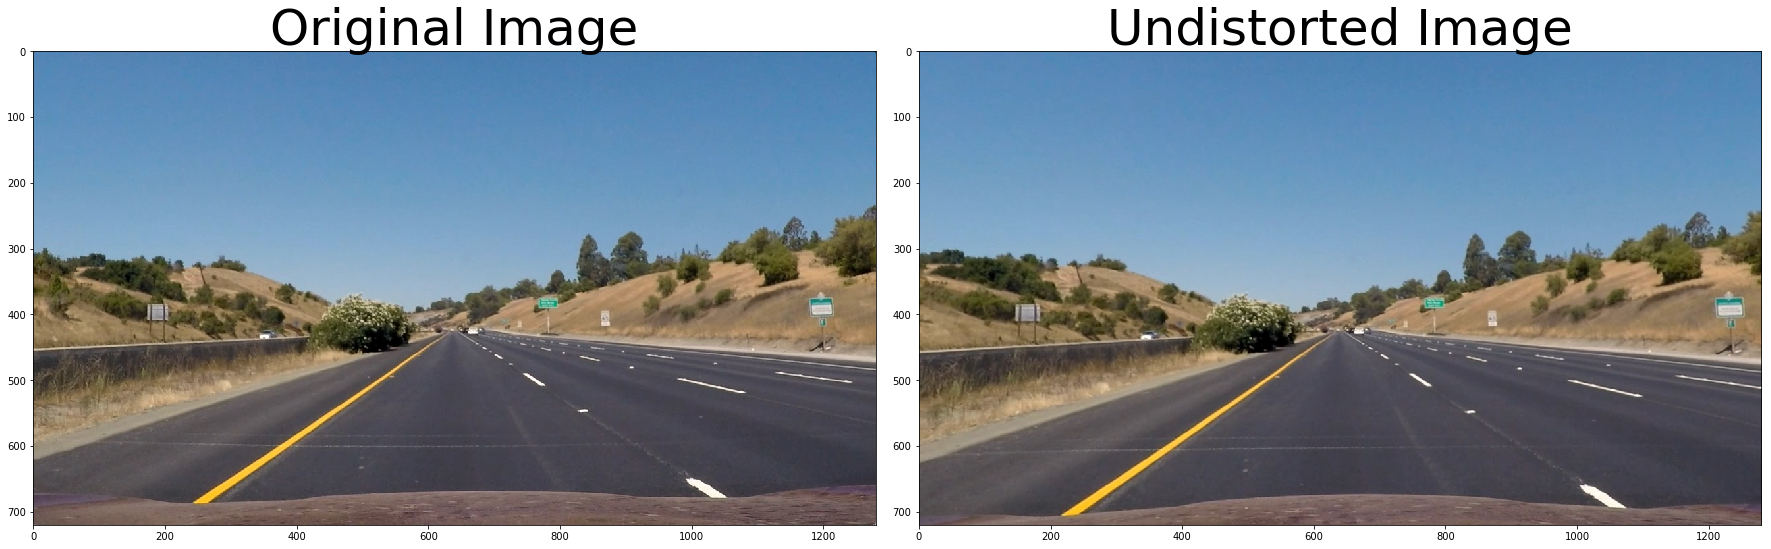

In [24]:
img = mpimg.imread('test_images\\straight_lines1.jpg')



undistorted = undistort_image(img, dist, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

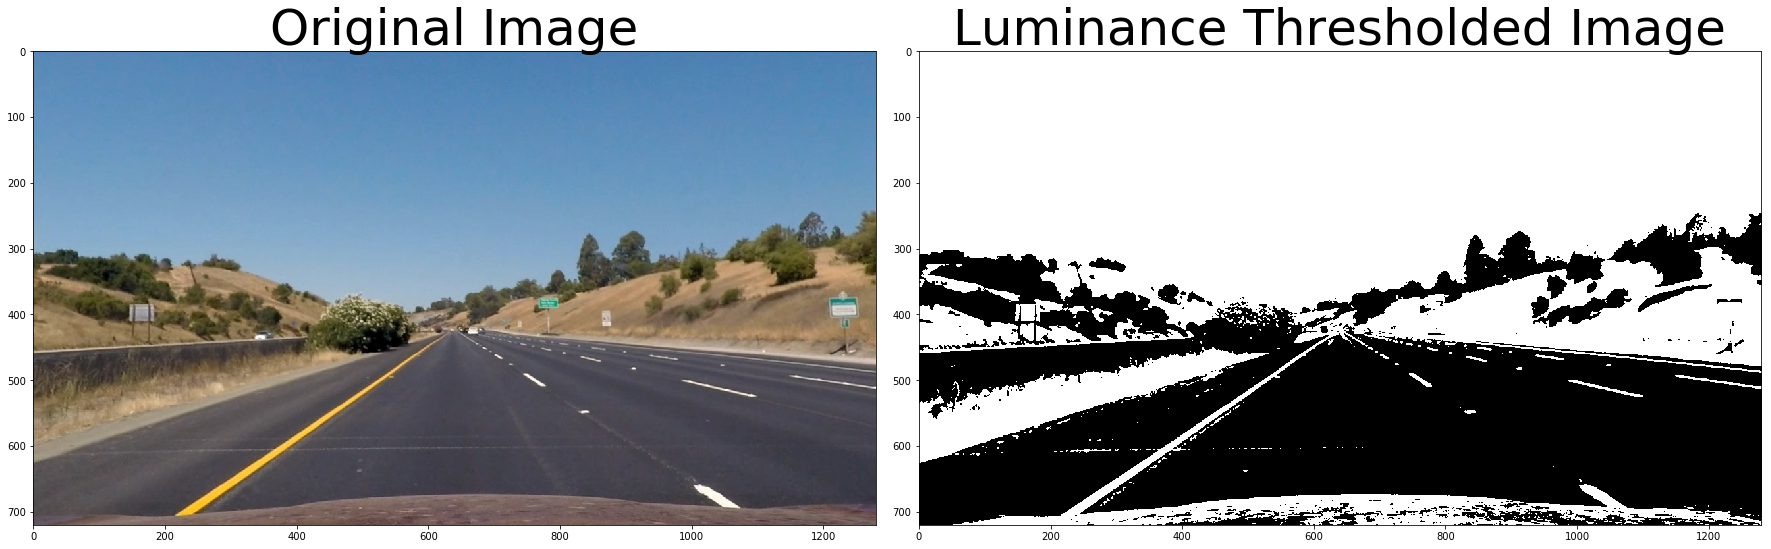

In [25]:
luminance_threshold = luminance_thres(undistorted, (100, 255))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undistorted)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(luminance_threshold, cmap='gray')
ax2.set_title('Luminance Thresholded Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

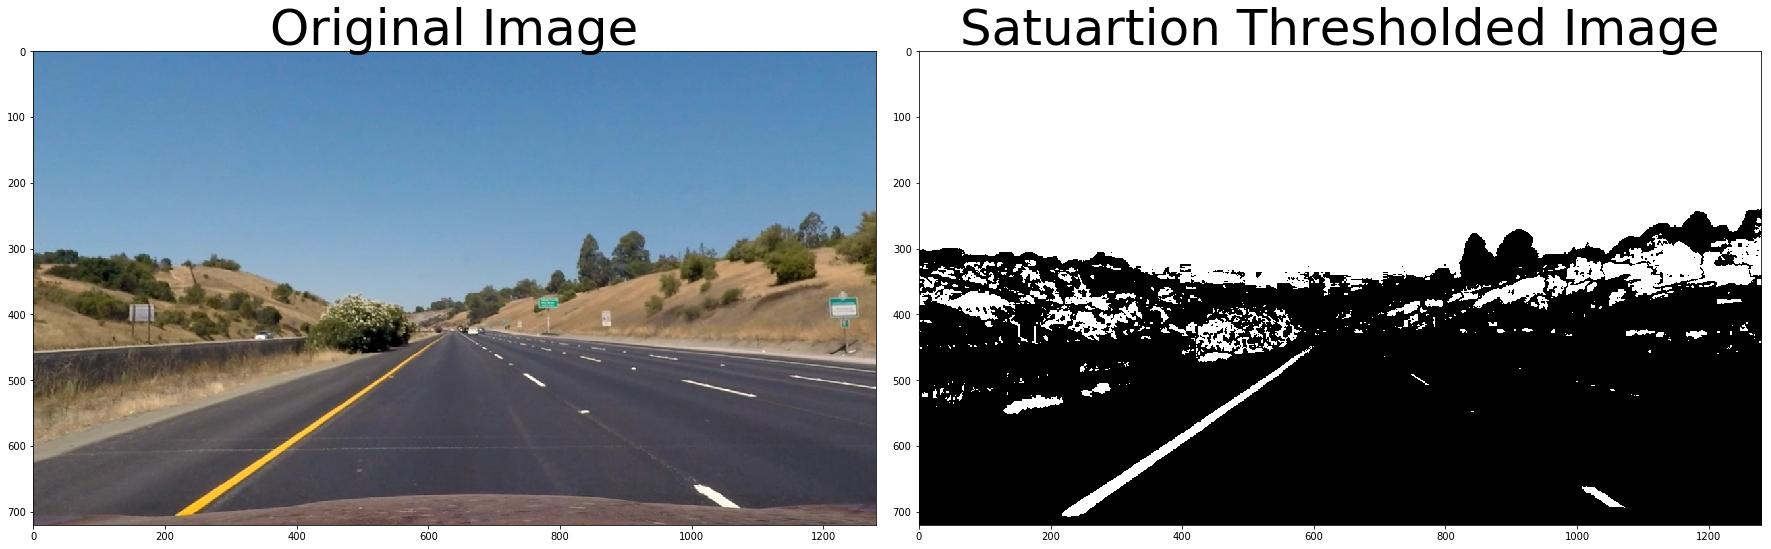

In [7]:
saturation_threshold = saturation_thres(undistorted, (80, 255))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undistorted)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(saturation_threshold, cmap='gray')
ax2.set_title('Satuartion Thresholded Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

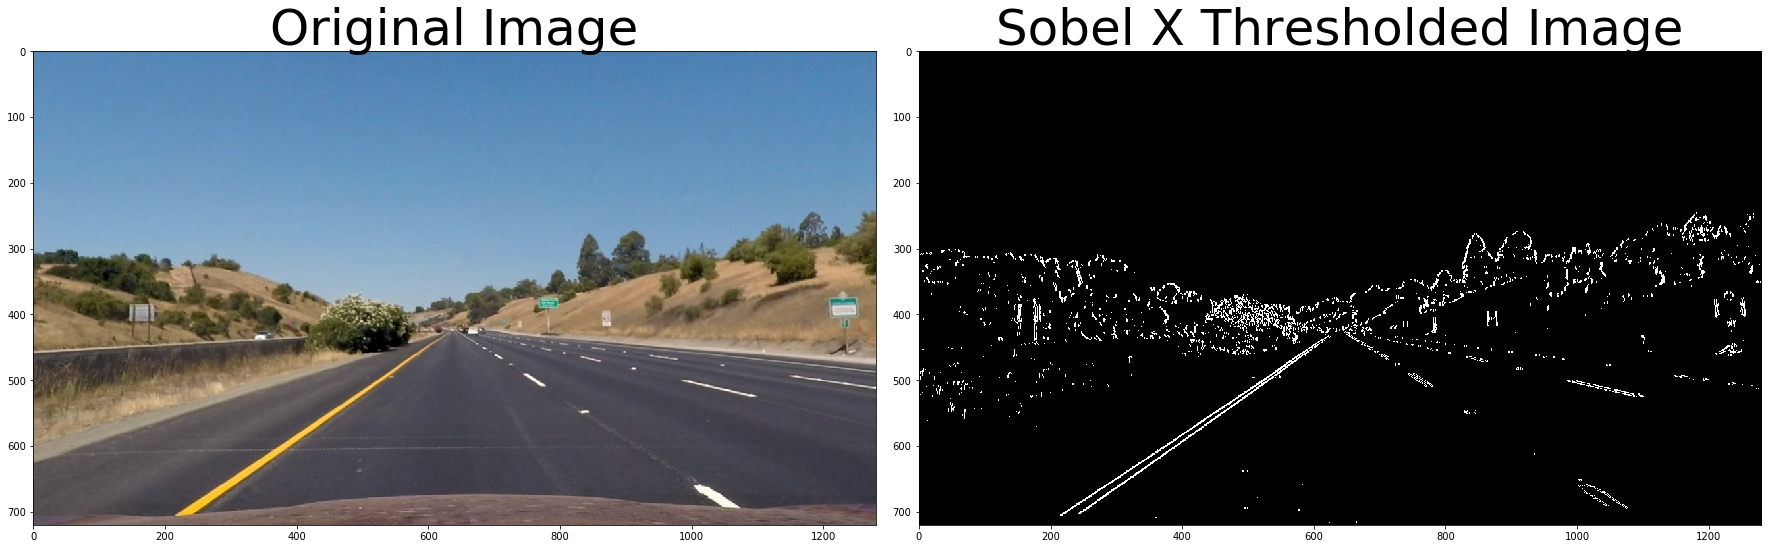

In [8]:
sobel_x = abs_sobel_x(undistorted, (30, 100),3)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undistorted)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(sobel_x, cmap='gray')
ax2.set_title('Sobel X Thresholded Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

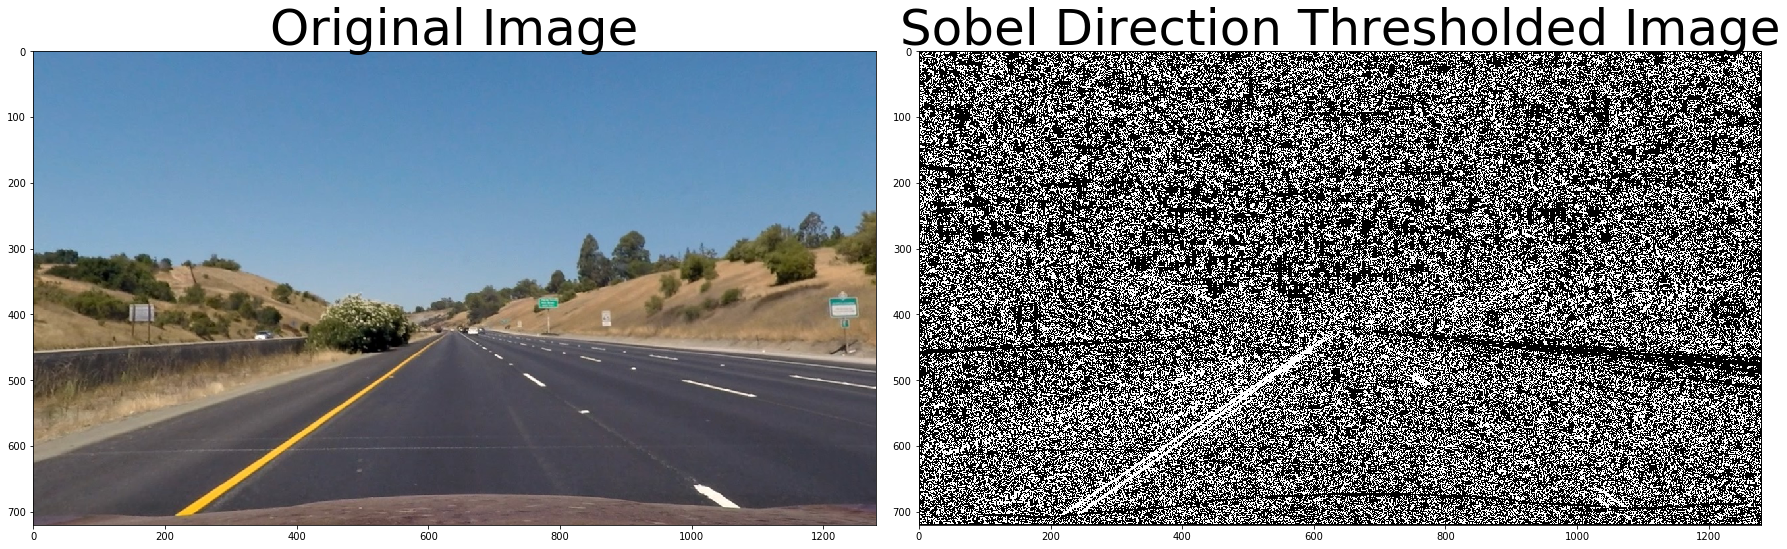

In [9]:
sobel_dir = abs_sobel_dir(undistorted, (0.7, 1.3),3)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undistorted)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(sobel_dir, cmap='gray')
ax2.set_title('Sobel Direction Thresholded Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

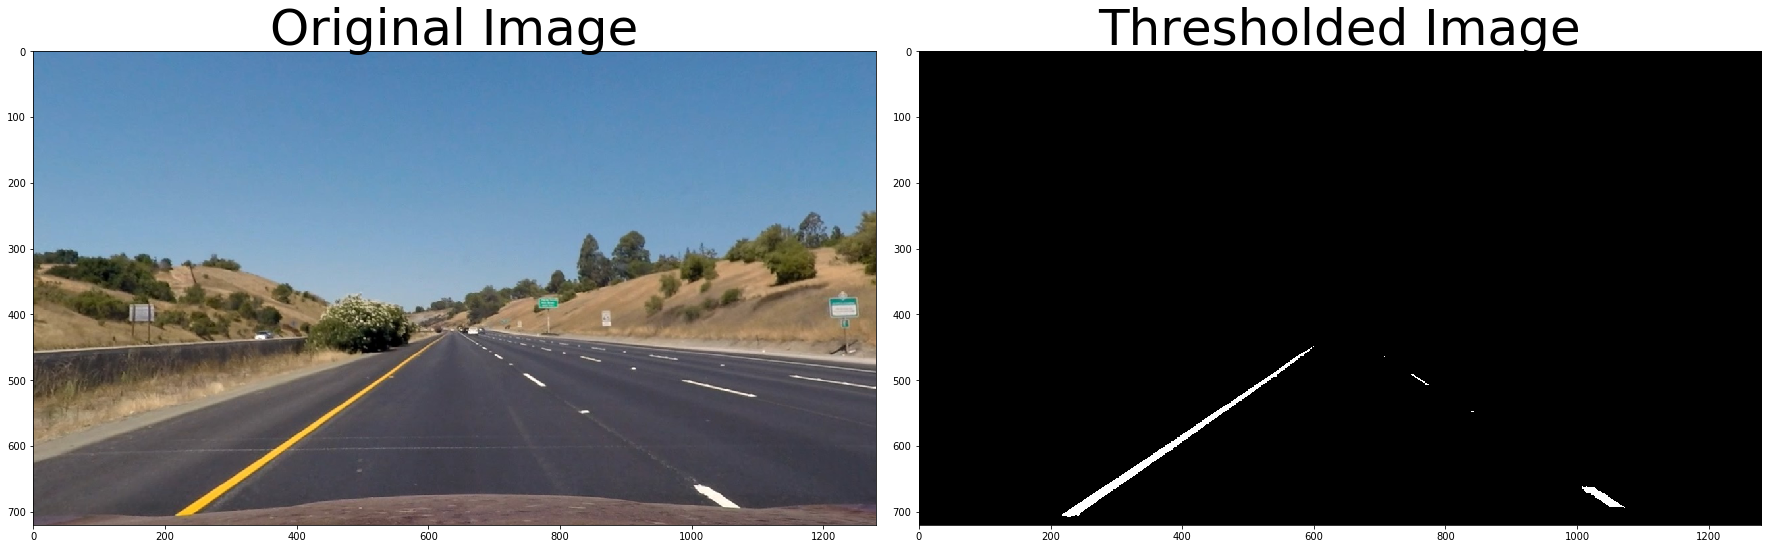

In [10]:
ysize = img.shape[0]
xsize = img.shape[1]

leftBottom = [round(0.1*xsize),ysize]
leftTop = [round(0.437*xsize),round(0.61*ysize)]
rightTop = [round(0.564*xsize),round(0.61*ysize)]
rightBottom = [round(0.94*xsize),ysize]

roi_satu = region_of_interest(saturation_threshold, [np.array([leftBottom,leftTop,rightTop,rightBottom], dtype=np.int32)])
roi_luminance = region_of_interest(luminance_threshold, [np.array([leftBottom,leftTop,rightTop,rightBottom], dtype=np.int32)])

binary = np.zeros_like(roi_satu)
binary[(roi_satu==1) & (roi_luminance==1)] = 1

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undistorted)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(binary, cmap='gray')
ax2.set_title('Thresholded Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [29]:
#calculating perspective transform matrix for specified src and destination points
src = np.float32([[200,720], [600, 447], [679,447], [1100,720]])
dst = np.float32([[300, 720], [300, 0], [900, 0], [900, 720]])
M = cv2.getPerspectiveTransform(src, dst)
M_1 = cv2.getPerspectiveTransform(dst, src)

In [30]:
#getting perspective transformed image

def perspective_transform(img, image_size):
    warped = cv2.warpPerspective(img, M, image_size, flags=cv2.INTER_LINEAR)
    return warped

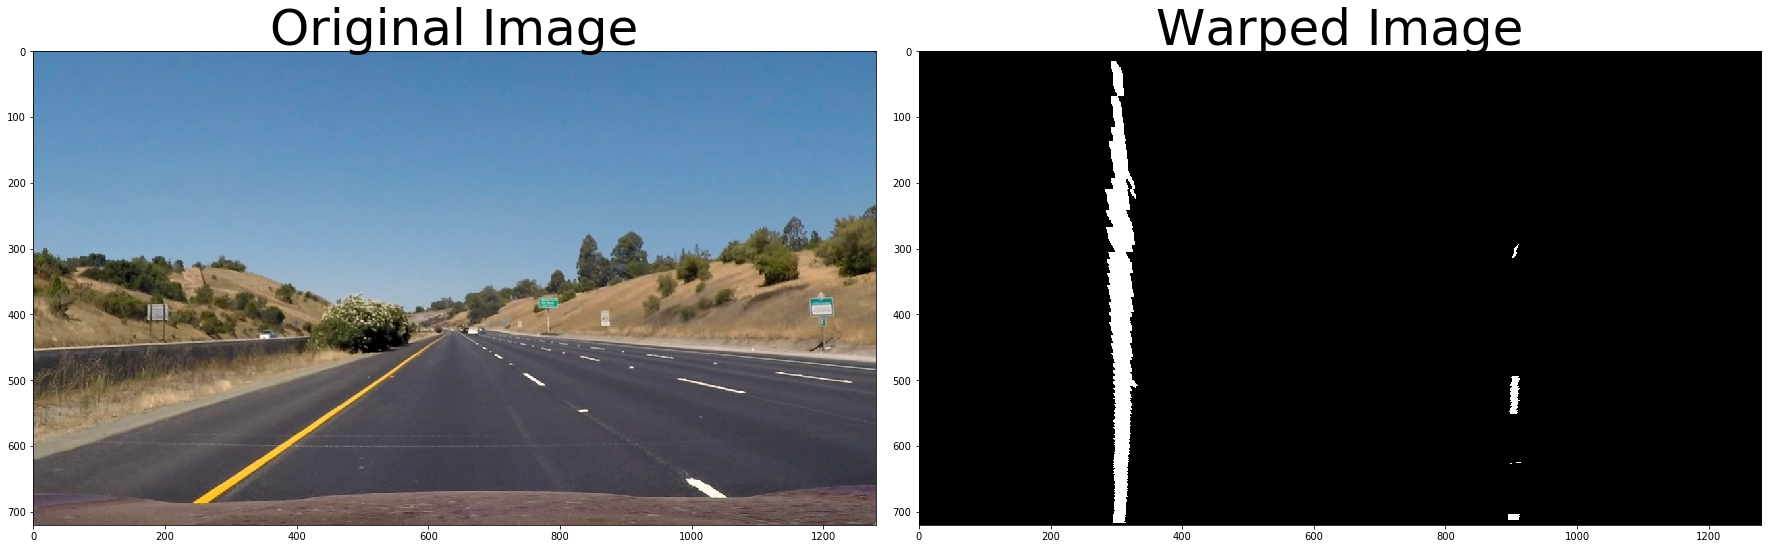

In [13]:


warped = perspective_transform(binary, binary.shape[::-1])

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped, cmap='gray')
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [31]:
#functiuon to perform sliding window search
def sliding_window(binary_warped):
    histogram=np.sum(binary_warped[binary_warped.shape[0]//2:,:],axis=0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2)
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit

In [15]:
#functiuon to perform sliding window search in limited region
def sliding_window_limited_region(binary_warped, left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit


In [16]:
#class containing pipeline and logic to store last 10 polynomial co-ordinates and use them every time
class LaneLineFinder(object):
    prev_left_fit = []
    prev_right_fit = []
    left_fit = []
    right_fit = []
    first = True
    
    prev_ten_left_fit = []
    prev_ten_right_fit = []
    
    def pipeline(self, image):
        undistorted = undistort_image(image, dist, mtx)
        transformed = thresholding(undistorted)
        warped = perspective_transform(transformed, transformed.shape[::-1])
        if self.first:
            self.left_fit, self.right_fit = sliding_window(warped)
            self.first = False
        else:
            self.prev_left_fit = np.mean(self.prev_ten_left_fit, axis=0)
            self.prev_right_fit = np.mean(self.prev_ten_right_fit, axis=0)
            self.left_fit, self.right_fit = sliding_window_limited_region(warped, self.prev_left_fit, self.prev_right_fit)
        ploty = np.linspace(0, transformed.shape[0]-1, transformed.shape[0] )
        left_fitx = self.left_fit[0]*ploty**2 + self.left_fit[1]*ploty + self.left_fit[2]
        right_fitx = self.right_fit[0]*ploty**2 + self.right_fit[1]*ploty + self.right_fit[2]
    
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))
        output_image = np.zeros_like(undistorted)
        cv2.fillPoly(output_image, np.array([pts], dtype=np.int32), (0,255,0))
        output_image = cv2.warpPerspective(output_image, M_1, output_image.shape[1::-1], flags=cv2.INTER_LINEAR)
        
        if(len(self.prev_ten_left_fit)>10):
            self.prev_ten_left_fit = self.prev_ten_left_fit[1:]
            self.prev_ten_right_fit = self.prev_ten_right_fit[1:]
        self.prev_ten_left_fit.append(self.left_fit)
        self.prev_ten_right_fit.append(self.right_fit)    
        
        img = cv2.addWeighted(undistorted, 1, output_image, 0.5, 0)
        self.prev_left_fit = self.left_fit
        self.prev_right_fit = self.right_fit
        
        left_curverad = radious_of_curvature(left_fitx, transformed.shape[0])
        right_curverad = radious_of_curvature(right_fitx, transformed.shape[0])
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img,'Radius Of Curvature = {0:.2f}(m)'.format(np.mean([left_curverad,right_curverad])),(50,50), font, 1,(255,255,255),2,cv2.LINE_AA)
        
        # compute the offset from the center
        lane_center = (right_fitx[transformed.shape[0]-1] + left_fitx[transformed.shape[0]-1])/2
        xm_per_pix = 3.7/700 # meters per pixel in x dimension
        center_offset_pixels = transformed.shape[1]/2 - lane_center
        center_offset_mtrs = xm_per_pix*center_offset_pixels
        if center_offset_mtrs>=0:
            towards = 'left'
        else:
            towards = 'right'
        cv2.putText(img,'Vehicle is {0:.2f}m '.format(abs(center_offset_mtrs))+towards+' of center',(50,100), font, 1,(255,255,255),2,cv2.LINE_AA)
#         imgvstack1 = np.vstack([img, undistorted])
#         imgvstack2 = np.vstack([np.dstack((transformed,transformed,transformed))*255, np.dstack((warped,warped,warped))*255])
#         img = np.hstack([imgvstack1,imgvstack2])
#         img = np.dstack((window,window,window))*255
        return img.astype(np.uint8)


In [17]:
video_processor = LaneLineFinder()

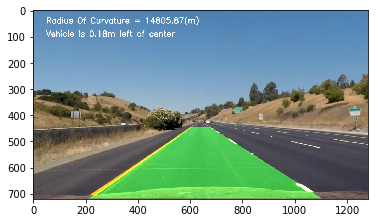

In [18]:
plt.imshow(video_processor.pipeline(mpimg.imread('test_images\\straight_lines1.jpg')))

In [19]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(video_processor.pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [05:06<00:00,  3.69it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 5min 8s
